<a href="https://colab.research.google.com/github/rikchik/Image-classification-using-CNN/blob/main/Image_classification_using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dataset="https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"

download_url(dataset,'.')

  0%|          | 0/135107811 [00:00<?, ?it/s]

In [ ]:
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./content')

In [ ]:
classes=os.listdir('./content/cifar10/train')
classes

['ship',
 'bird',
 'automobile',
 'airplane',
 'frog',
 'cat',
 'horse',
 'deer',
 'truck',
 'dog']

In [ ]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

In [ ]:
dataset = ImageFolder(root="./content/cifar10/train", transform=ToTensor())
test = ImageFolder(root="./content/cifar10/test",transform=ToTensor())

torch.Size([3, 32, 32]) 0


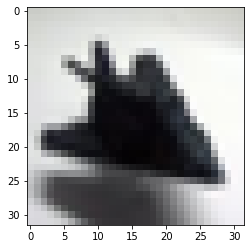

In [ ]:
img, label= dataset[0]
print(img.shape,label)
plt.imshow(img.permute(1,2,0))

torch.Size([3, 32, 32]) 0


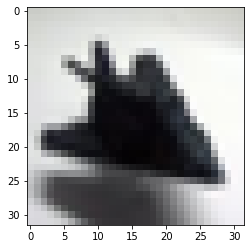

In [ ]:
def show_image(img,label):
  print(img.shape, label)
  plt.imshow(img.permute(1,2,0))

show_image(*dataset[0])

torch.Size([3, 32, 32]) 0


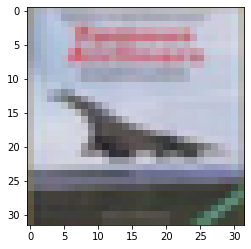

In [ ]:
show_image(*test[0])

In [ ]:
from torch.utils.data.dataloader import DataLoader

batch_size = 64

train_dl = DataLoader(dataset,batch_size=batch_size,shuffle=True) 
test = DataLoader(test,batch_size=len(test))

#Could've used a validation set too but the data I am working with is only 60,000 so I omitted it

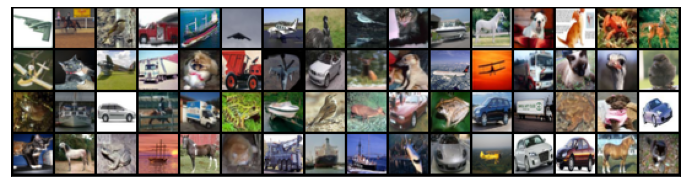

In [ ]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

show_batch(train_dl)

In [ ]:
from torch.nn import ReLU
import torch.nn as nn
import torch.nn.functional as F


In [ ]:

class cifar10model(nn.Module):
  def __init__(self):
    super().__init__()
    self.network1 = nn.Sequential(
    nn.Conv2d(3,16,3,padding=1),
    nn.Dropout(0.2),
    nn.ReLU(),
    nn.MaxPool2d(2,2),
    nn.Conv2d(16,64,3,padding=1),
    nn.Dropout(0.2),
    nn.ReLU(),
    nn.MaxPool2d(2,2)
    )#8
    self.network2=nn.Sequential(
    nn.Conv2d(64,128,3,padding=1),
    nn.ReLU(),
    nn.Conv2d(128,256,3,padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2,2))#4
    self.network3 = nn.Sequential(
    #nn.Conv2d(256,256,3,padding=1),
    #nn.ReLU(),
    nn.Conv2d(256,512,3,padding=1),
    nn.MaxPool2d(2,2),
    nn.Dropout(0.2)
    )
    self.network4=nn.Sequential(
    nn.Flatten(),
    )
    self.network5=nn.Sequential(
    nn.Dropout(0.1),
    nn.Linear(512*2*2,512),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(512,128),
    nn.ReLU(),
    nn.Linear(128,10),
    )

  def forward(self,xb):
    xb0=self.network1(xb)
    #print(xb0.shape)
    xb1=self.network2(xb0)
    #print(xb1.shape)
    xb2=self.network3(xb1)
    #print(xb2.shape)
    xb3=self.network4(xb2)
    #print(xb3.shape)
    return self.network5(xb3)

In [ ]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')

device=get_default_device()

In [ ]:
model = cifar10model().to(device)
model

cifar10model(
  (network1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Dropout(p=0.2, inplace=False)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): Dropout(p=0.2, inplace=False)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (network2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (network3): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Dropout(p=0.2, inplace=False)
  )


In [ ]:
from torch.optim import Adam


def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.sum(torch.eq(preds,labels))/len(preds)

def fit(model, train_dl,epochs):
  losses=[]
  l=torch.nn.CrossEntropyLoss()
  optimizer=Adam(model.parameters(),lr=0.0001)
  for epoch in range(epochs):
 
    model.train()
    for idx,(data, target) in enumerate(train_dl):
  
      data = data.to(device)
  
      target = target.to(device)
      optimizer.zero_grad()
      output = model(data)
      loss = l(output,target)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      losses.append(loss.item())
      if idx>0 and idx%100==0:
        print("Epochs:", epoch)
        print("Batch Num:",idx)
        print("Loss:",loss.item())
        #print("target:",target)
        print("Accuracy:",accuracy(output,target))
        print()
 

In [ ]:
fit(model,train_dl,30)

Epochs: 0
Batch Num: 100
Loss: 2.155017375946045
Accuracy: tensor(0.2188, device='cuda:0')

Epochs: 0
Batch Num: 200
Loss: 1.8503706455230713
Accuracy: tensor(0.3125, device='cuda:0')

Epochs: 0
Batch Num: 300
Loss: 1.7493438720703125
Accuracy: tensor(0.3750, device='cuda:0')

Epochs: 0
Batch Num: 400
Loss: 1.7269306182861328
Accuracy: tensor(0.3750, device='cuda:0')

Epochs: 0
Batch Num: 500
Loss: 1.8559694290161133
Accuracy: tensor(0.3281, device='cuda:0')

Epochs: 0
Batch Num: 600
Loss: 1.5604865550994873
Accuracy: tensor(0.3906, device='cuda:0')

Epochs: 0
Batch Num: 700
Loss: 1.5159424543380737
Accuracy: tensor(0.4219, device='cuda:0')

Epochs: 1
Batch Num: 100
Loss: 1.6408355236053467
Accuracy: tensor(0.3750, device='cuda:0')

Epochs: 1
Batch Num: 200
Loss: 1.4766300916671753
Accuracy: tensor(0.4062, device='cuda:0')

Epochs: 1
Batch Num: 300
Loss: 1.701174020767212
Accuracy: tensor(0.3750, device='cuda:0')

Epochs: 1
Batch Num: 400
Loss: 1.3845276832580566
Accuracy: tensor(0.421

In [ ]:
with torch.no_grad():
  for (img,label) in test:
    img=img.to(device)
    label=label.to(device)

    y_preds=model(img)
    
    print(f'Accuracy on test set: {accuracy(y_preds,label)}')

Accuracy on test set: 0.7322999835014343
